In [1]:
import torch
import einops
import torch.nn as nn
import polars as pr
import plotly.express as ex

from torch import Tensor
from random import random
from torch.utils.data import Dataset, DataLoader
from polars.dataframe.frame import DataFrame
from polars.series.series import Series
from typing import Optional, Dict, List, NoReturn, Callable, Generic, Any

import seris
import os
torch.set_default_device("cuda:0")
torch.cuda.empty_cache()

In [2]:
HOME = os.getenv("HOME")
train1 = HOME + "/Datasets/muld_OpenSubtitles/data/train-00000-of-00003-ae10b8591df9b61f.parquet"
train2 = HOME + "/Datasets/muld_OpenSubtitles/data/train-00001-of-00003-d297e02053936096.parquet"
train3 = HOME + "/Datasets/muld_OpenSubtitles/data/train-00002-of-00003-7c2c5fa1d6ac9938.parquet"
test = HOME + "/Datasets/muld_OpenSubtitles/data/test-00000-of-00001-30e0e85c508944e5.parquet"

In [3]:
dataset = seris.SimpleDataset(train1)
len(dataset)

9250

In [4]:
chunk = seris.dataset.GetData(dataset[0])
# chunk[:2]

In [5]:
tk = seris.Tokenizer(special_token= ["<reserved_1>","<reserved_2>" ,"<end>","<start>"] )
for i in dataset:
    tk.train(i)
tk.vocab_size

398

In [6]:
def get_batch_rand(tensor_data:Tensor, batch_size=32, dim=64):
    # ( batchsize*32 , ( input*64 ) )  , ( batchsize*32 , ( output*1 ))
    l = len(tensor_data) -1
    rnd = torch.randint( l-dim ,(batch_size,))
    x = torch.concat( [ tensor_data[i:i+dim].unsqueeze(0) for i in rnd ] ,dim=0)
    y = torch.concat( [ tensor_data[i+dim].unsqueeze(0) for i in rnd ] ,dim=0)
    return x,y

def get_batch(tensor_data:Tensor, batch_size=32, dim=64):
    # ( batchsize*32 , ( input*64 ) )  , ( batchsize*32 , ( output*1 ))
    length = len(tensor_data) -batch_size
    for i in range(length-dim):
        lst = list(range(i,i+batch_size))
        x_ = torch.concat( [ tensor_data[i:i+dim].unsqueeze(0) for i in lst ] ,dim=0)
        y_ = torch.concat( [ tensor_data[i+dim].unsqueeze(0) for i in lst ] ,dim=0)
        yield x_,y_

In [7]:
model_arg = seris.model.ModelConfig(
    dim = 32,
    lr = 1e-3,
    d_model = 32,
    vocab_size = tk.vocab_size,
    nheads = 8,
    batch_size = 64,
)

net = seris.Transformer(
    config = model_arg
)

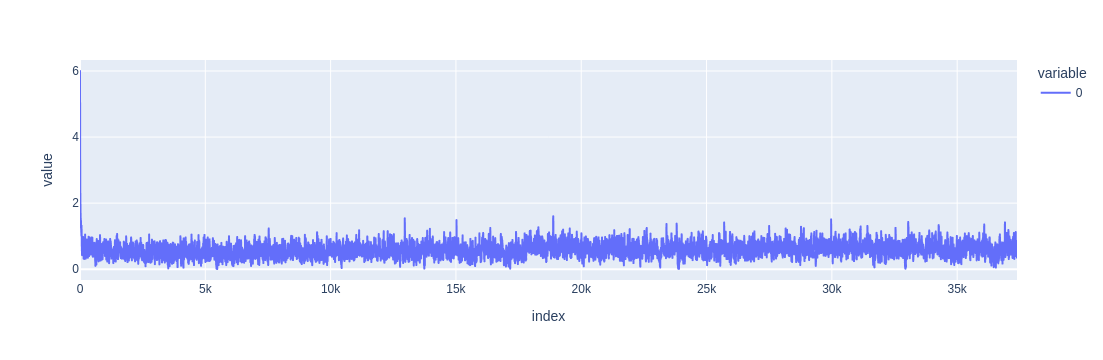

In [8]:
net = net.train()

optim = torch.optim.AdamW(params=net.parameters(),lr=model_arg.lr)
criterion = nn.CrossEntropyLoss()
loss_ = []
for corpus in dataset:
    for x,y in get_batch(tk.encode(corpus),batch_size = model_arg.batch_size,dim = model_arg.dim):
        y_ = net(x)
        optim.zero_grad()
        loss = criterion(y_,y)
        loss.backward()
        optim.step()
        loss_.append( loss.item() )
    ex.line(loss_).show()
    break

In [9]:
net = net.eval()
dim = model_arg.dim
context_length = 200

x = get_batch_rand(tk.encode(corpus), batch_size=1,dim=dim)[0]
print("".join(tk.decode(x.view(-1))))
for _ in range(context_length):
    x = x[:,-dim:]
    y = net.generate(x)
    print("".join(tk.decode(y.view(-1))), end="" , flush=True)
    x = torch.concat( [x , y] , dim=-1)

 bin gleich wieder da.
Geht!
- D
ane s Mumich, wass zel s?
- als enzums sis alzunm iger ind DuniBastel?
- Riss nebum des mass euc.
- Galenzünec.
- Wim gih.
- Wem grüden Vorldepzinge's!
- Wir gnauss eih mäslwiss ls surs Rick izuns lle